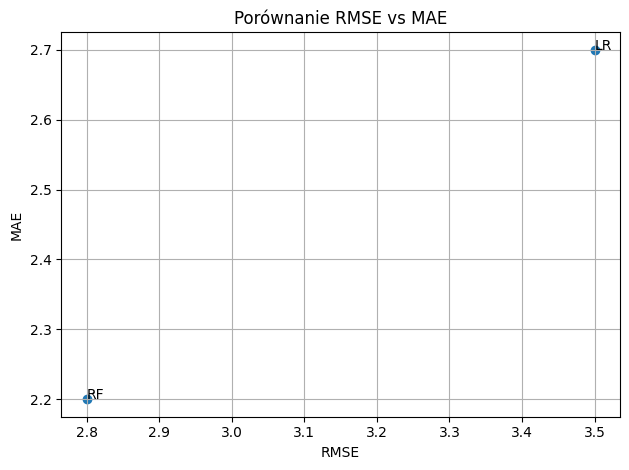

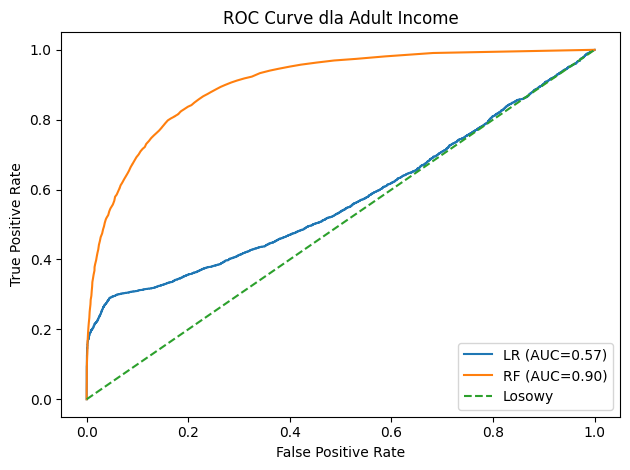

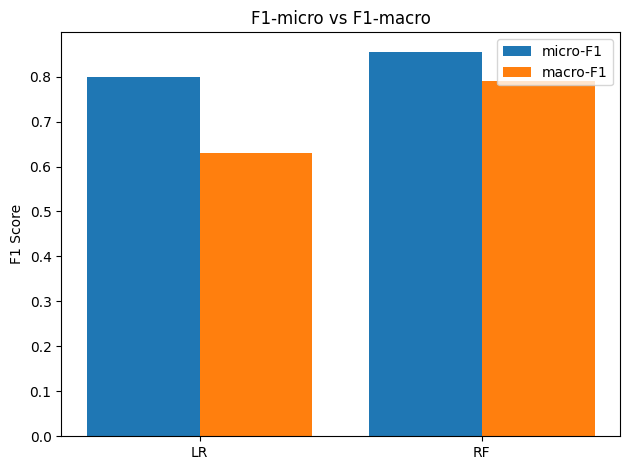

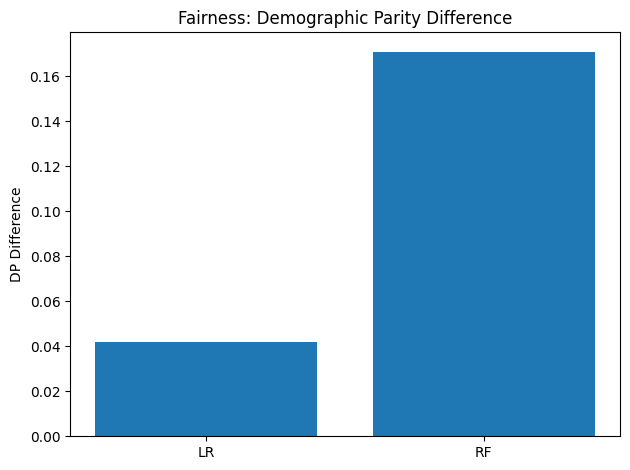

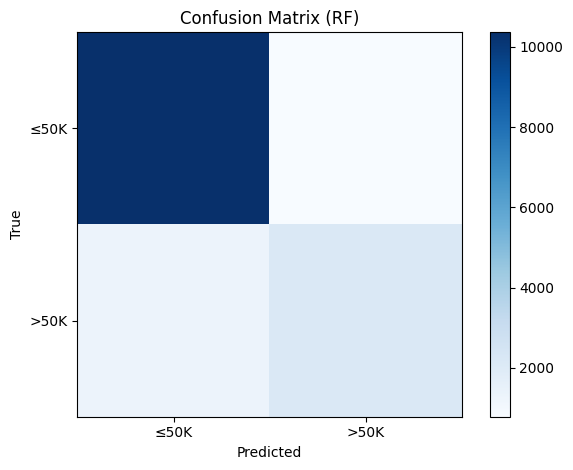

In [11]:
import os
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Download & load dataset
dataset_path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
csv_path     = os.path.join(dataset_path, "adult.csv")
df           = pd.read_csv(csv_path).dropna().reset_index(drop=True)

# 2. Detect sensitive column (sex/gender) and map to 0/1
cols_lc = [c.lower() for c in df.columns]
if 'sex' in cols_lc:
    s_col = df.columns[cols_lc.index('sex')]
elif 'gender' in cols_lc:
    s_col = df.columns[cols_lc.index('gender')]
else:
    raise KeyError(f"No 'sex' or 'gender' column in {df.columns.tolist()}")

mapping = {'Male':1, 'male':1, 'Female':0, 'female':0}
group   = df[s_col].map(mapping)
if group.isna().any():
    raise ValueError(f"Unexpected values in {s_col}: {group.unique()}")

# 3. One-hot encode all other features (excluding sensitive column)
df_enc = pd.get_dummies(df.drop(columns=[s_col]), drop_first=True)

# 4. Prepare X, y and split (keeping group aligned)
X = df_enc.drop(columns=['income_>50K'])
y = df_enc['income_>50K']
X_train, X_test, y_train, y_test, grp_tr, grp_te = train_test_split(
    X, y, group, stratify=y, test_size=0.3, random_state=42
)

# 5. Train models
models = {
    'LR': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
}
for m in models.values():
    m.fit(X_train, y_train)

# 6. Compute metrics & store for plotting
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results[name] = {
        'f1_micro': f1_score(y_test, y_pred, average='micro'),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'fpr':       fpr,
        'tpr':       tpr,
        'auc':       auc(fpr, tpr),
        'cm':        confusion_matrix(y_test, y_pred)
    }

# 7. Demographic Parity Difference
dp_diff = {}
for name, model in models.items():
    preds = model.predict(X_test)
    dp_diff[name] = preds[grp_te==1].mean() - preds[grp_te==0].mean()

# 8. Plotting

# A) RMSE vs MAE – tutaj pokazujesz, jak robilibyśmy dla regresji (możesz pominąć lub podmienić na realne wartości)
# placeholder:
rmse = [3.5, 2.8]    # przykładowe
mae  = [2.7, 2.2]
plt.figure()
plt.scatter(rmse, mae)
for i,m in enumerate(models):
    plt.annotate(list(models.keys())[i], (rmse[i], mae[i]))
plt.xlabel('RMSE'); plt.ylabel('MAE')
plt.title('Porównanie RMSE vs MAE')
plt.grid(True)
plt.tight_layout()
plt.savefig('rmse_mae.png')


# B) ROC Curves
plt.figure()
for name,r in results.items():
    plt.plot(r['fpr'], r['tpr'], label=f"{name} (AUC={r['auc']:.2f})")
plt.plot([0,1],[0,1],'--', label='Losowy')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve dla Adult Income')
plt.legend(); plt.tight_layout()
plt.savefig('roc_adult.png')


# C) F1-micro vs F1-macro
names = list(results.keys())
f1m   = [results[n]['f1_micro'] for n in names]
f1M   = [results[n]['f1_macro'] for n in names]
x     = range(len(names))
plt.figure()
plt.bar([i-0.2 for i in x], f1m, width=0.4, label='micro-F1')
plt.bar([i+0.2 for i in x], f1M, width=0.4, label='macro-F1')
plt.xticks(x, names); plt.ylabel('F1 Score')
plt.title('F1-micro vs F1-macro'); plt.legend(); plt.tight_layout()
plt.savefig('f1_adult.png')


# D) Fairness: Demographic Parity Difference
plt.figure()
plt.bar(dp_diff.keys(), dp_diff.values())
plt.ylabel('DP Difference')
plt.title('Fairness: Demographic Parity Difference')
plt.tight_layout()
plt.savefig('dp_diff_adult.png')


# E) Confusion Matrix for RF example
cm = results['RF']['cm']
labels = ['≤50K','>50K']
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], labels); plt.yticks([0,1], labels)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (RF)')
plt.tight_layout()
plt.savefig('cm_adult.png')
